In [1]:
# !pip3 install pygad
import numpy as np
from integer_rref import i4mat_rref
# from sympy import Matrix

import pygad
import matplotlib.pyplot as plt
from cytools import Polytope
from cytools.triangulation import Triangulation
from cytools.utils import find_new_affinely_independent_points

from cytools import read_polytopes, fetch_polytopes


Info: A more recent version of CYTools is available: v1.0.4 -> v1.0.11.
We recommend upgrading before continuing.
On Linux and macOS you can update CYTools by running 'cytools --update'
and on Windows you can do this by running the updater tool.



In [80]:
# p = Polytope([[ 0,  0,  0],
#    [-1, -1,  0],
#    [-1,  1,  0],
#    [ 2, -1,  0],
#    [ 0,  0, -1],
#    [ 0,  0,  1],
#    [-1,  0,  0],
#    [ 0, -1,  0],
#    [ 1, -1,  0]])

# p = Polytope([
#     [-1, 6, 2, 3],
#     [0, -1, 2, 3],
#     [0, 0, -1, 0],
#     [0, 0, 0, -1],
#     [1, 6, 2, 3]
# ])

# p = Polytope([
#     [-1, 4, 2, 3],
#     [0, -1, 1, 2],
#     [0, -1, 2, 3],
#     [0, 0, -1, 0],
#     [0, 0, 0, -1],
#     [0, 0, 2, 3],
#     [0, 2, 0, 1],
#     [1, 4, 2, 3]
# ])

# p = Polytope([[ 1,  0,  0,  0],
#        [ 0,  1,  0,  0],
#        [ 2,  4,  5,  0],
#        [ 3,  3,  0,  5],
#        [-6, -8, -5, -5]])

p = Polytope([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1],
    [-1,-1,0,0],
    [-1,-1,-1,-1],
])

pts = p.points()[1:]


gene_size = pts.shape[0]*2

In [85]:
p

A 4-dimensional reflexive lattice polytope in ZZ^4

In [86]:
# p.triangulate().simplices()

In [87]:
p.find_2d_reflexive_subpolytopes()

[A 2-dimensional lattice polytope in ZZ^4]

In [88]:
def get_indices(p, subp):
    return [np.where(np.all(v == p, axis=1))[0][0] for v in subp]

def boundary(simplices):
    dsimplices = []
    for s in simplices:
        for i in range(1, len(s)):
            dsimplices.append(
                np.append(s[:i], s[(i+1):]))

    dsimplices = np.asarray(dsimplices)
    return dsimplices

def restrict(dsimplices, subp_vertices):
    sub_simplices = np.where(np.all(np.isin(dsimplices, subp_vertices), axis=1))[0]
    sub_simplices = dsimplices[sub_simplices]

    local_sub_simplices = []
    for s in sub_simplices:
        local_s = []
        for v in s:
            local_s.append(np.where(subp_vertices == v)[0][0])
        local_sub_simplices.append(local_s)
    return np.unique(local_sub_simplices, axis=0)

def project(vertices):
    vertices_copy = np.array(vertices, copy=True)
    W = np.asarray(i4mat_rref(vertices.shape[0], vertices.shape[1], vertices_copy)[0]).astype(np.float64)
    local_vertices = np.round(vertices@np.linalg.pinv(W))
    idx = np.argwhere(np.all(local_vertices[..., :] == 0, axis=0))
    
    return np.delete(local_vertices, idx, axis=1)

In [89]:
def reduce_polytope(vertices):
    vertices_copy = np.array(vertices, copy=True)
    W = np.asarray(i4mat_rref(vertices.shape[0], vertices.shape[1], vertices_copy)[0]).astype(np.float64)
    local_vertices = np.round(vertices@np.linalg.pinv(W))
    idx = np.argwhere(np.all(local_vertices[..., :] == 0, axis=0))
    
    return Polytope(np.delete(local_vertices, idx, axis=1))

In [90]:
gene_size//2

6

In [91]:

solutions = []


def compose(x, *args):
    out = x
    for f in args:
        out = f(out)
    return out


fibration_dimension = 2
def fitness_func(ga_instance, solution, solution_idx):
    pts_sol = solution[:gene_size//2]
    mask = (pts_sol > 0)
    vertices = pts[mask]

    error = 0
    if vertices.size == 0:
        return -1000

    error += (np.linalg.matrix_rank(vertices) - fibration_dimension)**2
    p_reduced = reduce_polytope(vertices)

    error += (1 - p_reduced.is_reflexive())**2
    error += (fibration_dimension - p_reduced.dimension())**2

    # Construct a triangulation 
    heights_sol = solution[gene_size//2:]
    heights = [-1e3] + [pt.dot(pt) + heights_sol[i] for i, pt in enumerate(pts)]

    t = p.triangulate(heights = heights)
    # error += (1-t.is_star())**2 + (1-t.is_fine())**2 + (1-t.is_regular())**2

    

    if error == 0:
        # Restrict triangulation
        subsimplices = restrict(
            dsimplices = compose(t.simplices(), *([boundary]*(p.dimension() - fibration_dimension))), #boundary(t.simplices()),
            subp_vertices = get_indices(
                p.points(), Polytope(vertices).points()))

        try:
            tsub = Triangulation(
                triang_pts = project(Polytope(vertices).points()),
                simplices = subsimplices)
        except Exception as e:
            print(e)
            # print(subsimplices)
            return -1000

        # Check that every vertex is used
        used_indices = set.union(*[set(s) for s in tsub.simplices()])
        is_fine = all(v in used_indices for v in p_reduced._triang_pt_inds(None))
        # triang_pts = tsub.points()[p_reduced._triang_pt_inds(None),:]
        # is_fine = len(set.union(*[set(s) for s in tsub.simplices()])) == len(triang_pts)
        error += (1-tsub.is_star())**2 + (1-is_fine)**2 + (1-tsub.is_regular())**2
    else:
        error += 1000
    if error <= 0:
        solutions.append((vertices, t, tsub))
    return -error

In [92]:
# Initialize GA

ga_instance = pygad.GA(
    fitness_func=fitness_func,
    num_genes=gene_size,
    save_best_solutions=False,

    num_generations=500,
    num_parents_mating=10,
    sol_per_pop=20,

    init_range_low=-1,
    init_range_high=1,
    gene_space = {'low': -1, 'high': 1},
    gene_type=float,

    parent_selection_type="rws",
    keep_parents=-1,
    # stop_criteria="reach_0",
    crossover_type="two_points",
    mutation_type="random",
    keep_elitism=10,
    mutation_percent_genes=20)

In [93]:
ga_instance.run()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


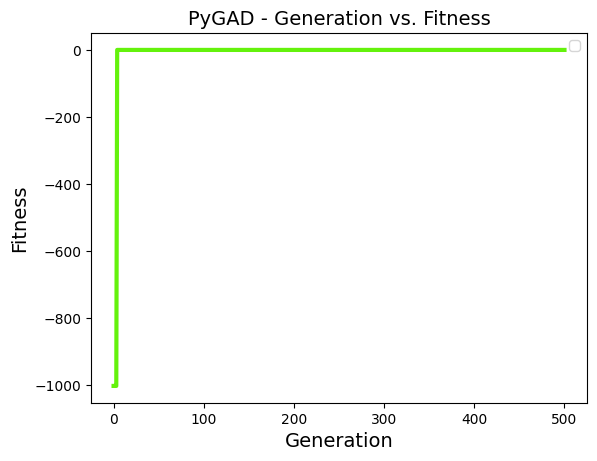

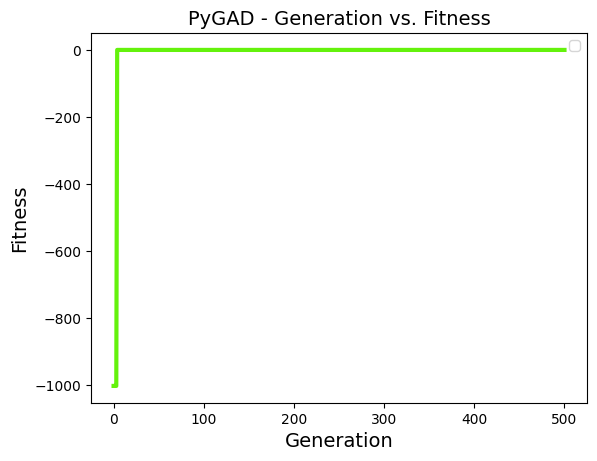

In [94]:
ga_instance.plot_fitness()

In [96]:
solutions[0]

(array([[-1, -1,  0,  0],
        [ 0,  1,  0,  0],
        [ 1,  0,  0,  0]]),
 A fine, regular, star triangulation of a 4-dimensional point configuration with 7 points in ZZ^4,
 A fine, regular, star triangulation of a 2-dimensional point configuration with 4 points in ZZ^2)